In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "drive/My Drive/Projects/MusicGenreClassification"

/content/drive/My Drive/Projects/MusicGenreClassification


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [4]:
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras.layers import (Input, Dense,Conv2D,Dropout,Activation,
                                     BatchNormalization,Flatten,MaxPool2D,)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
tf.config.experimental.set_memory_growth = True
from sklearn.model_selection import LeaveOneOut,KFold

In [5]:
import os
import json
import random

import librosa
import librosa.display

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report


## Load Data

In [6]:
DATASET_PATH = os.path.join(os.getcwd(), 'data.json')

def load_data(dataset_path):
    with open(dataset_path, 'r') as file:
        data = json.load(file)
        
        class_names = data["class_names"]
        inputs = np.array(data['mfcc'])
        targets = np.array(data['labels'])
        
        return inputs, targets , class_names

In [8]:
inputs, outputs, class_names = load_data(DATASET_PATH)
inputs = inputs.reshape((-1, 130, 13,1)) / 255

In [9]:
y_dataframe = pd.DataFrame(outputs)

In [10]:
counts = {}
for i in range(10):
    counts[i] = len(y_dataframe[y_dataframe[0] == i])

In [11]:
train_data_counts = []
for key,value in counts.items():
    train_data_counts.append(value)
train_data_counts

[999, 990, 1000, 1000, 1000, 999, 1000, 1000, 999, 999]

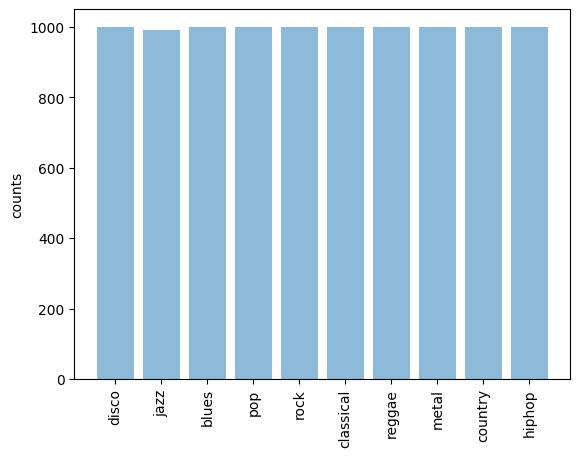

In [12]:
# Checking if train_data is balanced

plt.rcdefaults()

objects = class_names
y_pos = np.arange(len(train_data_counts))
performance = train_data_counts

plt.bar(y_pos, train_data_counts, align='center', alpha=0.5)
plt.xticks(y_pos, objects,rotation=90)
plt.ylabel('counts')

plt.show()

In [13]:
outputs = to_categorical(outputs)

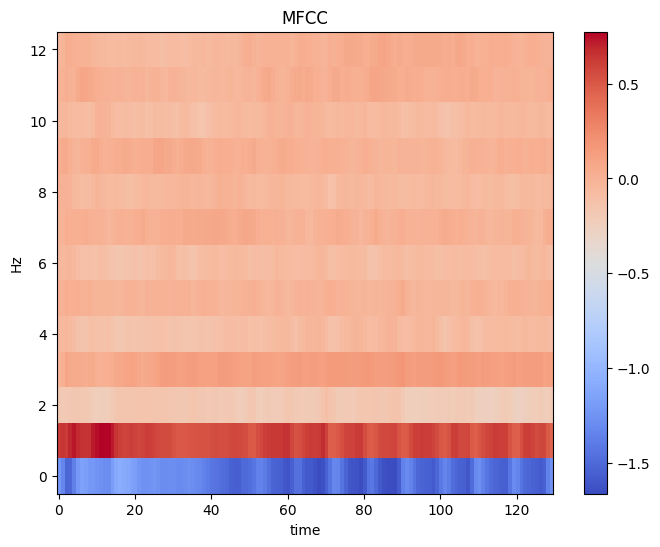

In [14]:
# plotting one sample

image_number = random.randint(0,inputs.shape[0])
fig, ax = plt.subplots( figsize=(8, 6))
m_slaney = inputs[image_number].T.reshape((13,130))
img = ax.imshow(m_slaney, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
ax.set(title='MFCC')
ax.set_xlabel('time')
ax.set_ylabel('Hz')

fig.colorbar(img);

## Model

In [ ]:
results = []
acc_results = []
iterator = iter(dataset)
K = 5
kfold = KFold(n_splits=K, shuffle=True)

for train, test in kfold.split(inputs, outputs):

    model_input = Input(shape=(130,13,1))
    x = model_input

    x = Conv2D(512,kernel_size=3,strides=2,padding="same",activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256,kernel_size=3,strides=2,padding="same",activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256,kernel_size=3,strides=2,padding="same",activation=None)(x)
    x = MaxPool2D(pool_size=3,strides=2,padding='same')(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128,kernel_size=3,strides=2,padding="same",activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64,kernel_size=3,strides=2,padding="same",activation=None)(x)
    x = MaxPool2D(pool_size=3,strides=2,padding='same')(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)

    x = Conv2D(32,kernel_size=3,strides=2,padding="same",activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)

    x = Conv2D(16,kernel_size=3,strides=2,padding="same",activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(10,activation=None)(x)
    model_output = Activation("softmax")(x)
    model = Model(model_input,model_output,name="genre_classifier")
    model.compile(loss="categorical_crossentropy",optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])

    hist = model.fit(inputs[train], outputs[train],batch_size=64,epochs=200)
    
    test_result = model.evaluate(inputs[test], outputs[test])
    acc_results.append(test_result[1])
    results.append(hist)

Epoch 1/200
125/125 [==============================] - 6s 38ms/step - loss: 2.4756 - accuracy: 0.1342
Epoch 2/200
125/125 [==============================] - 5s 37ms/step - loss: 2.2029 - accuracy: 0.2001
Epoch 3/200
125/125 [==============================] - 5s 38ms/step - loss: 2.0988 - accuracy: 0.2500
Epoch 4/200
125/125 [==============================] - 5s 38ms/step - loss: 2.0109 - accuracy: 0.2877
Epoch 5/200
125/125 [==============================] - 5s 38ms/step - loss: 1.9328 - accuracy: 0.3161
Epoch 6/200
125/125 [==============================] - 5s 38ms/step - loss: 1.8669 - accuracy: 0.3489
Epoch 7/200
125/125 [==============================] - 5s 38ms/step - loss: 1.7965 - accuracy: 0.3846
Epoch 8/200
125/125 [==============================] - 5s 38ms/step - loss: 1.7565 - accuracy: 0.4023
Epoch 9/200
125/125 [==============================] - 5s 38ms/step - loss: 1.7058 - accuracy: 0.4153
Epoch 10/200
125/125 [==============================] - 5s 38ms/step - loss: 1.663

In [ ]:
# model.summary()

# Training

In [ ]:
acc_results

[0.9014014005661011,
 0.8853279948234558,
 0.8798197507858276,
 0.8768151998519897,
 0.9008512496948242]

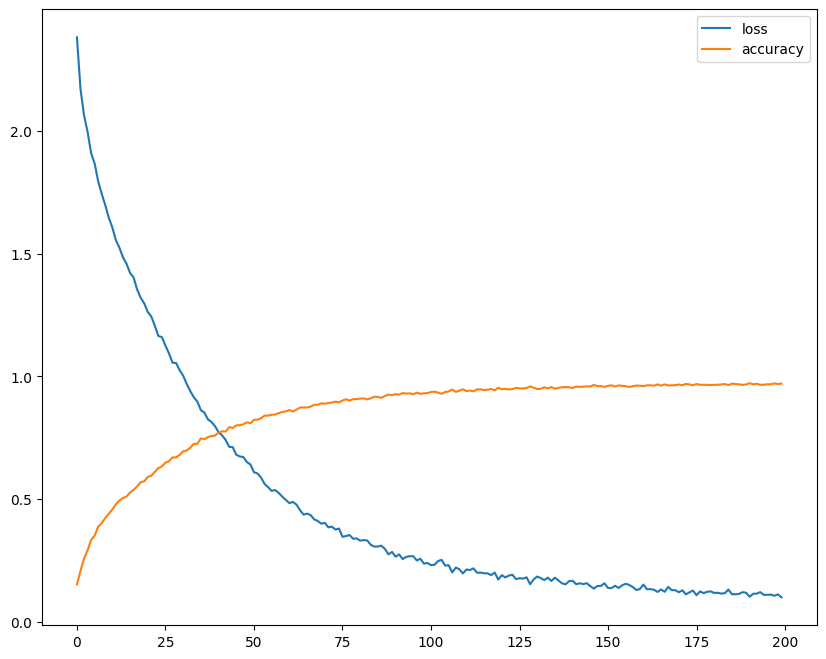

In [ ]:
pd.DataFrame(results[0].history).plot(figsize=(10,8))

# Evaluation

In [ ]:
model.evaluate(inputs[test],outputs[test])

63/63 [==============================] - 0s 8ms/step - loss: 0.4980 - accuracy: 0.9009


[0.4979597330093384, 0.9008512496948242]

In [ ]:
y_pred = model.predict(inputs[test])

print(classification_report(outputs[test].argmax(axis=1),y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       174
           1       0.93      0.97      0.95       201
           2       0.87      0.96      0.91       198
           3       0.90      0.94      0.92       181
           4       0.88      0.75      0.81       216
           5       0.99      0.98      0.98       209
           6       0.95      0.80      0.87       199
           7       0.90      0.92      0.91       201
           8       0.86      0.90      0.88       189
           9       0.88      0.92      0.90       229

    accuracy                           0.90      1997
   macro avg       0.90      0.90      0.90      1997
weighted avg       0.90      0.90      0.90      1997



In [ ]:
for index,item in enumerate(class_names):
    print(f"{index} -> {item}")

0 -> disco
1 -> jazz
2 -> blues
3 -> pop
4 -> rock
5 -> classical
6 -> reggae
7 -> metal
8 -> country
9 -> hiphop


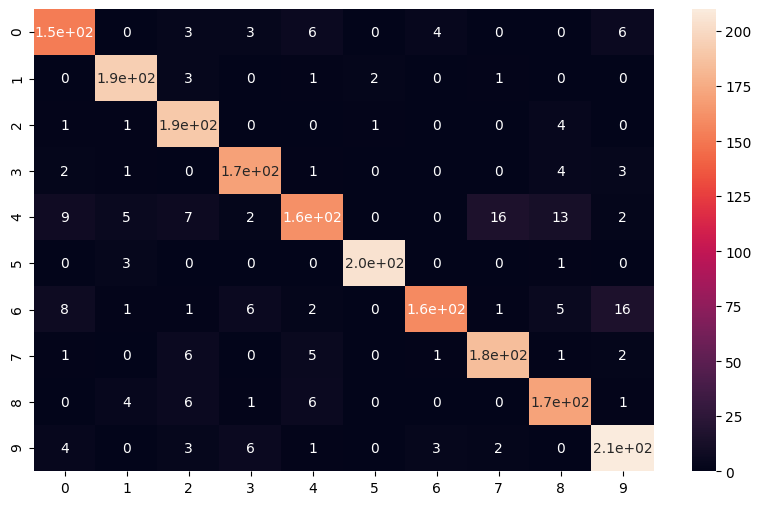

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(outputs[test].argmax(axis=1),y_pred.argmax(axis=1)),annot=True)

In [ ]:
save_model(model,"genre_classification.h5")

In [16]:
# model = load_model("genre_classification.h5")

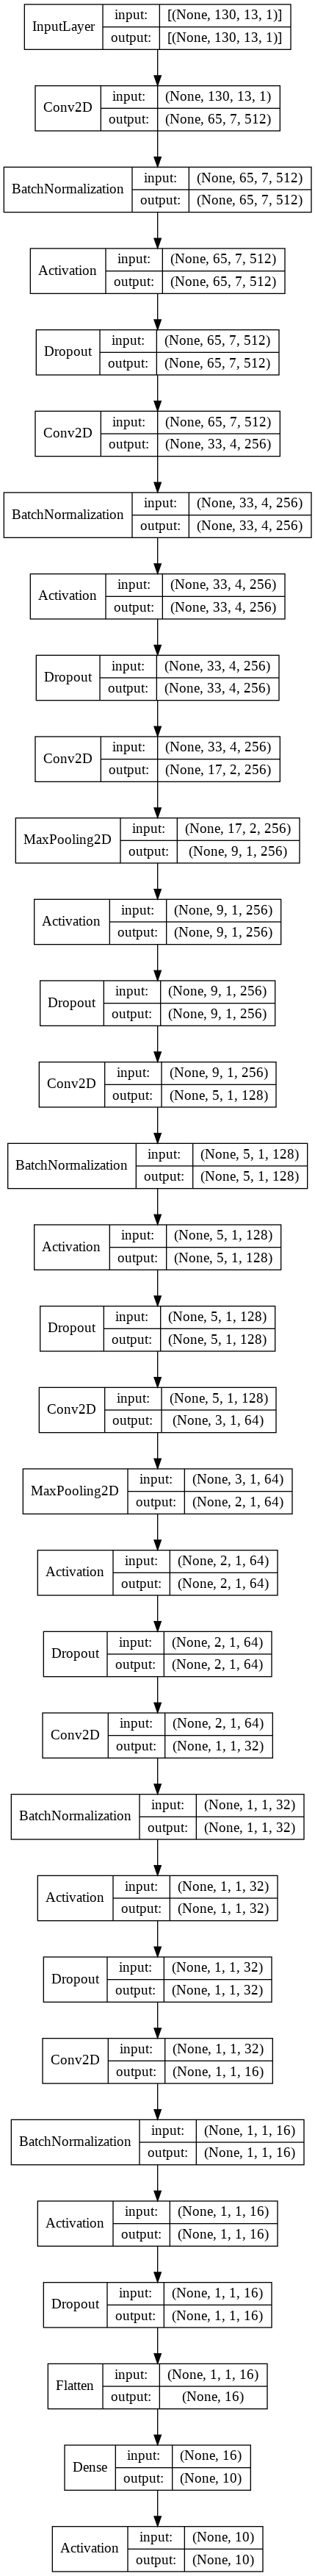

In [17]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=False
)